# Notes
This Jupyter Notebook provides you with some basic scaffolding to get you started on the [A3: Gesture Recognizer assignment](https://canvas.uw.edu/courses/1311479/assignments/4756082). In particular, I wrote some parser code and some initial data structures to parse and load the gesture logs recorded with the [A3: Gesture Recorder](https://github.com/jonfroehlich/CSE599Sp2019/tree/master/Assignments/A3-OfflineGestureRecognizer/GestureRecorder).

## Getting Started
1. The first thing you need to do is to change the logPath variable to point to the directory with your gesture logs. Scroll down to the "Load the Data" cell
2. Then, you should be able to select Cell->Run All in the File Menu above and the data should be read in.
3. Hopefully, in class, we will have time to visualize and analyze these signals a bit

## Dynamic Time Warping
If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
```
import sys
!{sys.executable} -m pip install fastdtw
```
See https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ for more details

In [2]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampMs, x, y, z, mag=[]):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampMs = sensorTimestampMs.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # calculate the magnitude of the signal
        if len(mag) == 0:
            self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        else:
            self.mag = mag.astype(float)
        
        self.sampleLengthInSecs = (self.currentTimeMs[-1] - self.currentTimeMs[0]) / 1000.0
        self.samplesPerSecond = len(self.currentTimeMs) / self.sampleLengthInSecs 
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Creates a new padded version of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    # See: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.pad.html
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x_padded = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y_padded = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z_padded = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag_padded = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)
        
    # Creates a new padded version of each data array with the mean of that array. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    # See: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.pad.html
    def pad_with_mean(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x_padded = np.pad(self.x, (0, arrayLengthDiff), 'mean')
        self.y_padded = np.pad(self.y, (0, arrayLengthDiff), 'mean')
        self.z_padded = np.pad(self.z, (0, arrayLengthDiff), 'mean')
        self.mag_padded = np.pad(self.mag, (0, arrayLengthDiff), 'mean')

# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.accelLogFilename = os.path.basename(accelLogFilenameWithPath)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData)
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
    def setProcessedAccel(self, x, y, z, mag):
        self.processed_accel = SensorData(self.accel.sensorType, self.accel.currentTimeMs, 
                                          self.accel.sensorTimestampMs, x, y, z, mag)
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gestureName, self.trialNum, self.accelLogFilename)

In [3]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        timeMs = filenameParts[1]
        numRows = int(filenameParts[2])
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
        
        print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # CSE599TODO: You'll want to loop through the sensor signals and preprocess them
    # Some things to explore: padding signal to equalize length between trials, smoothing, detrending, and scaling
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            # preprocess each signal
            x = 0; # no-op just delete this
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [4]:
# Load the data

# You should change the path to the location of the log files on your system
# Showing how to do this on the Mac
# logPath = '/Users/jonf/Dropbox/CSE599_PrototypingInteractive_2019Sp/A03-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\Teaching\MyClasses\CSE599_PrototypingInteractive_2019Sp\Assignments\A3-OfflineGestureRecognizer\Gestures"

# or if you move your gesture logs to the root dir of your Jupyter Notebook, this should work
logPath = './JonGestureLogs'

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

Found 60 csv files in ./JonGestureLogs
gestureName=Baseball Throw timeMs=1556730655270 numRows=306
gestureName=Bunny Hops timeMs=1556730986737 numRows=376
gestureName=Midair 'S' timeMs=1556730884249 numRows=142
gestureName=Baseball Throw timeMs=1556730674052 numRows=331
gestureName=Midair Clockwise 'O' timeMs=1556730710698 numRows=224
gestureName=Forehand Tennis timeMs=1556730590478 numRows=269
gestureName=Midair 'S' timeMs=1556730898598 numRows=113
gestureName=Glasses timeMs=1557796482008 numRows=363
gestureName=Shake timeMs=1556730925933 numRows=250
gestureName=Baseball Throw timeMs=1556730664027 numRows=333
gestureName=Midair Zorro 'Z' timeMs=1556730840228 numRows=206
gestureName=Midair Counter-clockwise 'O' timeMs=1556730792847 numRows=221
gestureName=Forehand Tennis timeMs=1556730581836 numRows=255
gestureName=Baseball Throw timeMs=1556730646381 numRows=280
gestureName=Backhand Tennis timeMs=1556730548371 numRows=254
gestureName=Midair Zorro 'Z' timeMs=1556730831607 numRows=156
ge

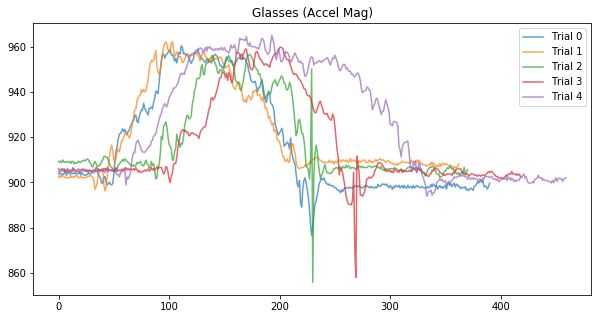

In [5]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


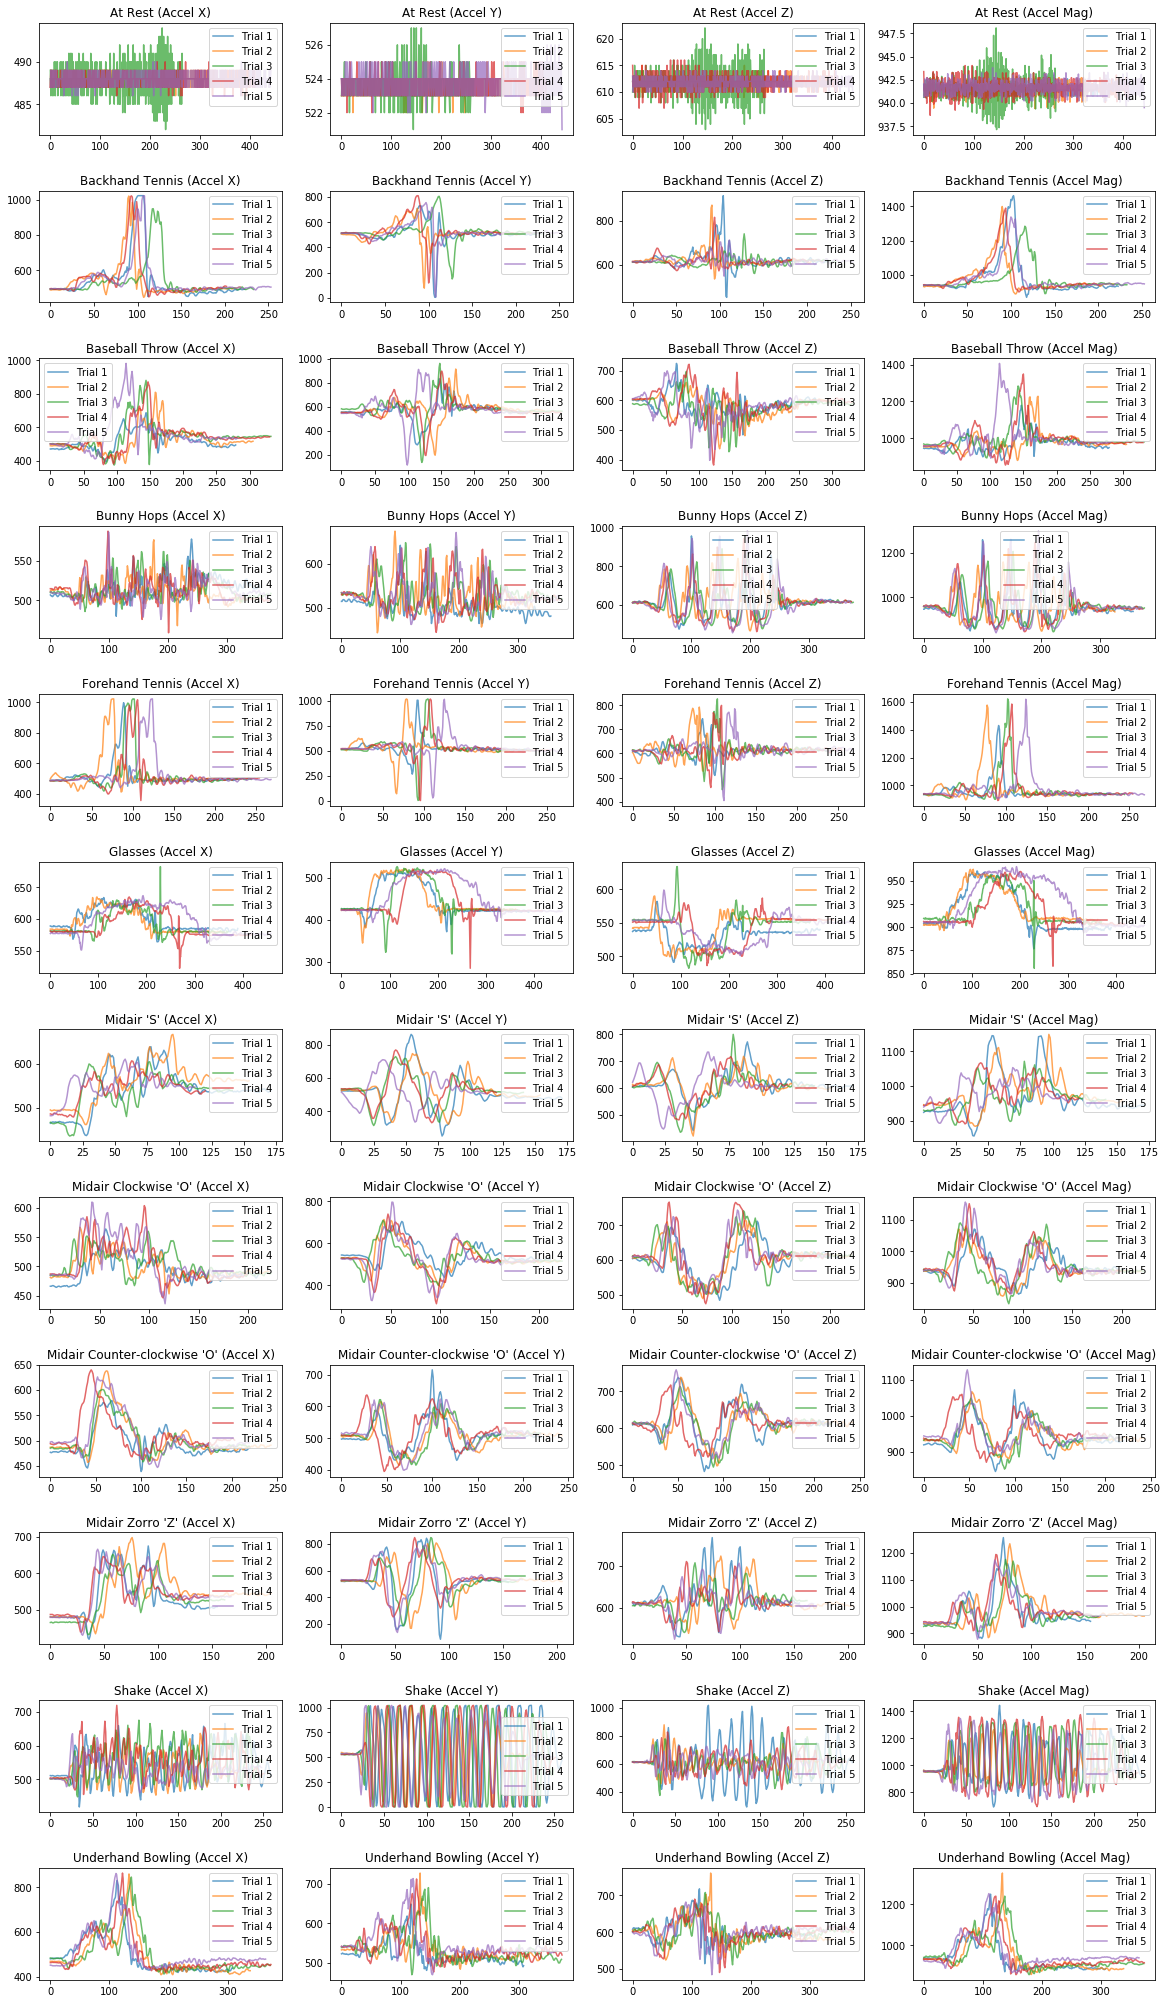

In [6]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1


In [ ]:
# Start analyzing and comparing these gesture signals.
# Think about:
#  - What patterns do you see in the data?
#  - What kind of filtering might be useful?
#  - How can you best align the signals for comparison? (e.g., hint: scroll down to see the Euclidean distance comparisons)
#  - What kind of signal transforms might be useful? (e.g., ffts, derivative waveforms)
#  - What is the simplest way we can compare two signals?
#  - What classes might you want to create to help you keep things organized? (e.g., your k-fold experiments and results)
#  - For k-fold cross validation, check out: http://scikit-learn.org/stable/modules/cross_validation.html or implement your own


# Smooth, align, and pad gestures

In [44]:
#def build_model():
#def classify():

#def smooth(x,window_len=25,window='hanning'):
def smooth(x,window_len=25,window='flat'):
    #Original code is from
    #https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    #
    
    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def align_fft(a, b):
    #This method is modified from 
    #https://stackoverflow.com/questions/4688715/find-time-shift-between-two-similar-waveforms
    #
    
    min_len = np.min([len(a), len(b)])
    
    af = scipy.fft(a[:min_len])
    bf = scipy.fft(b[:min_len])
    c = scipy.ifft(af * scipy.conj(bf))

    time_shift = np.argmax(abs(c))
    
    if time_shift < min_len/2:
        return True, time_shift
    else:
        return False, min_len - time_shift
    

## Only smoothing

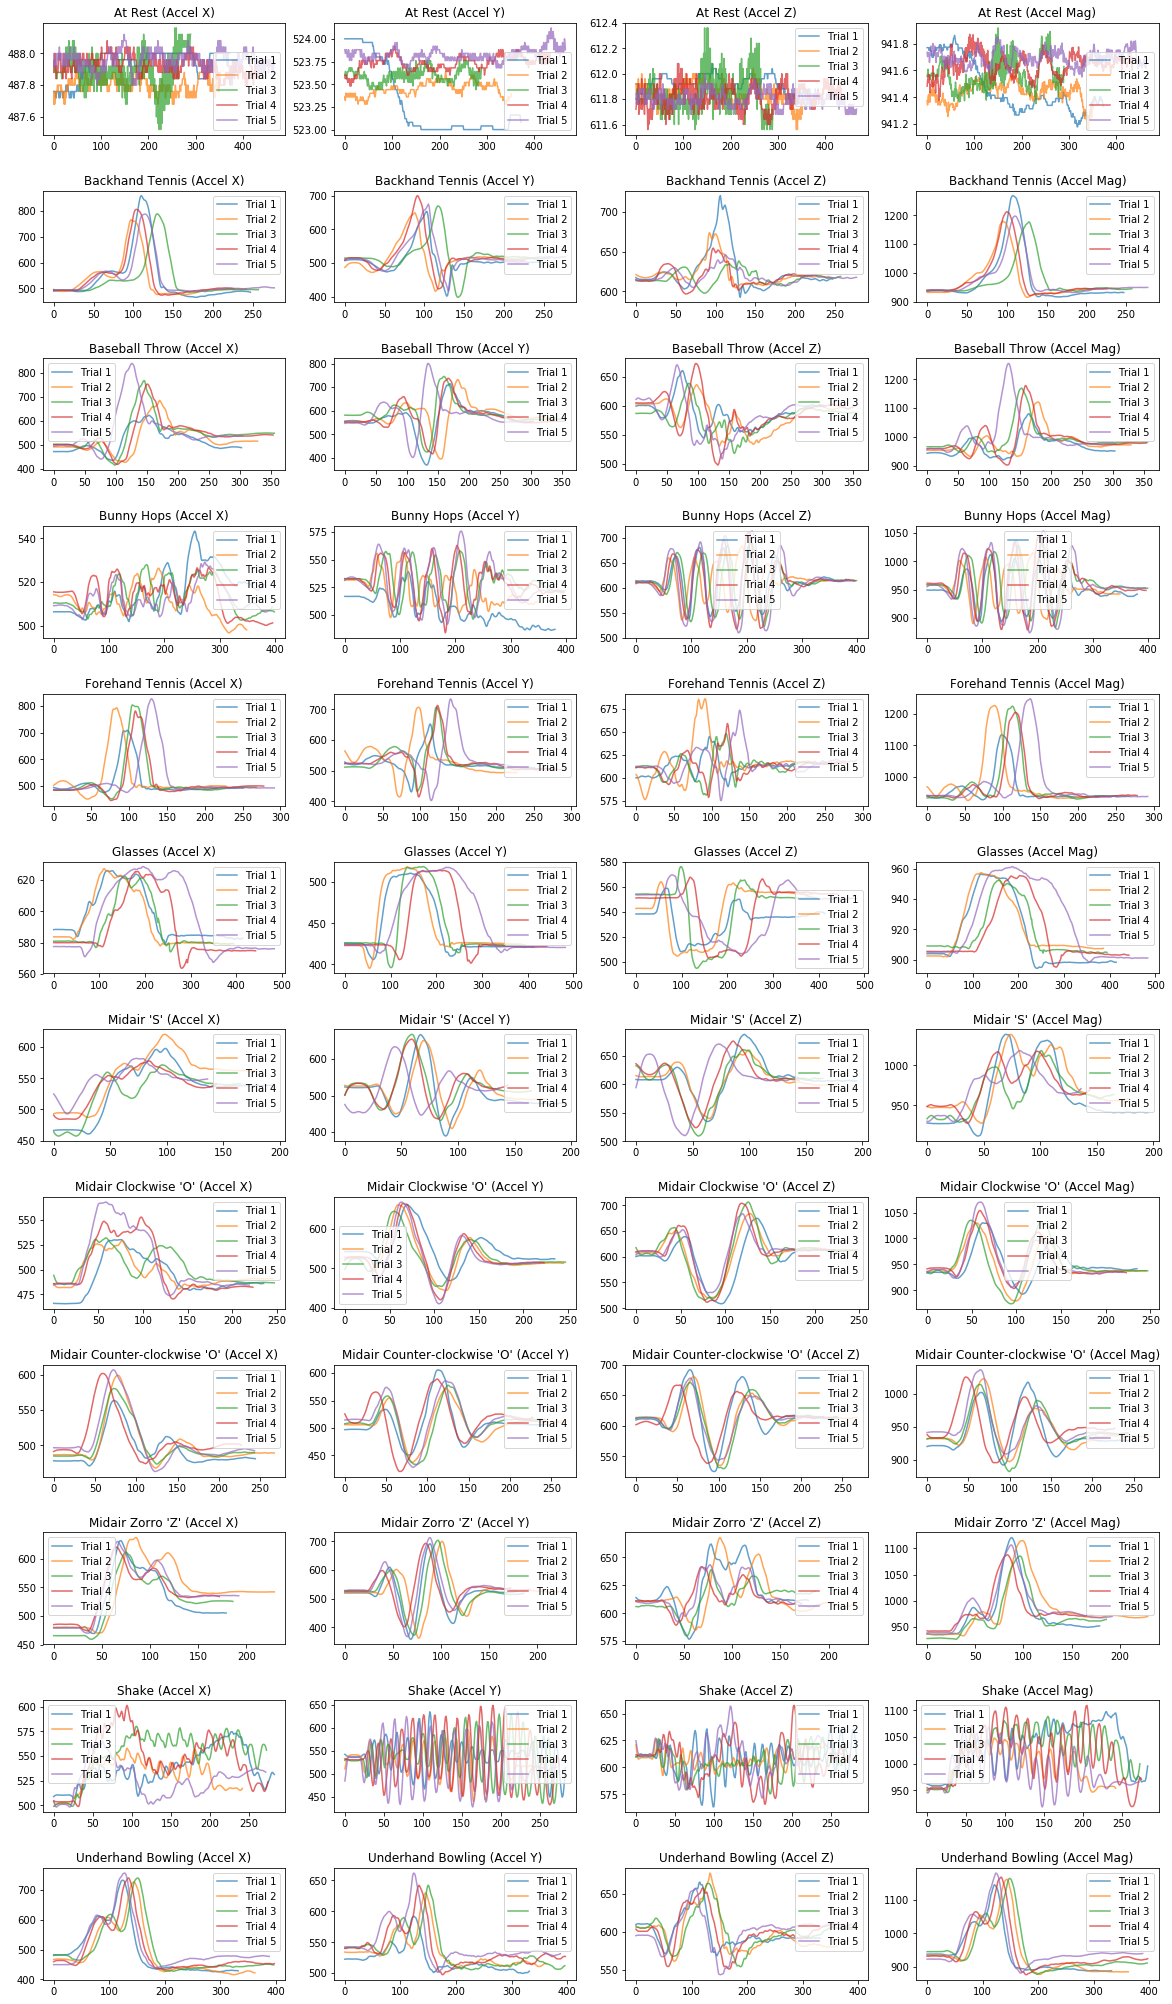

In [50]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(smooth(trial.accel.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(smooth(trial.accel.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(smooth(trial.accel.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(smooth(trial.accel.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1

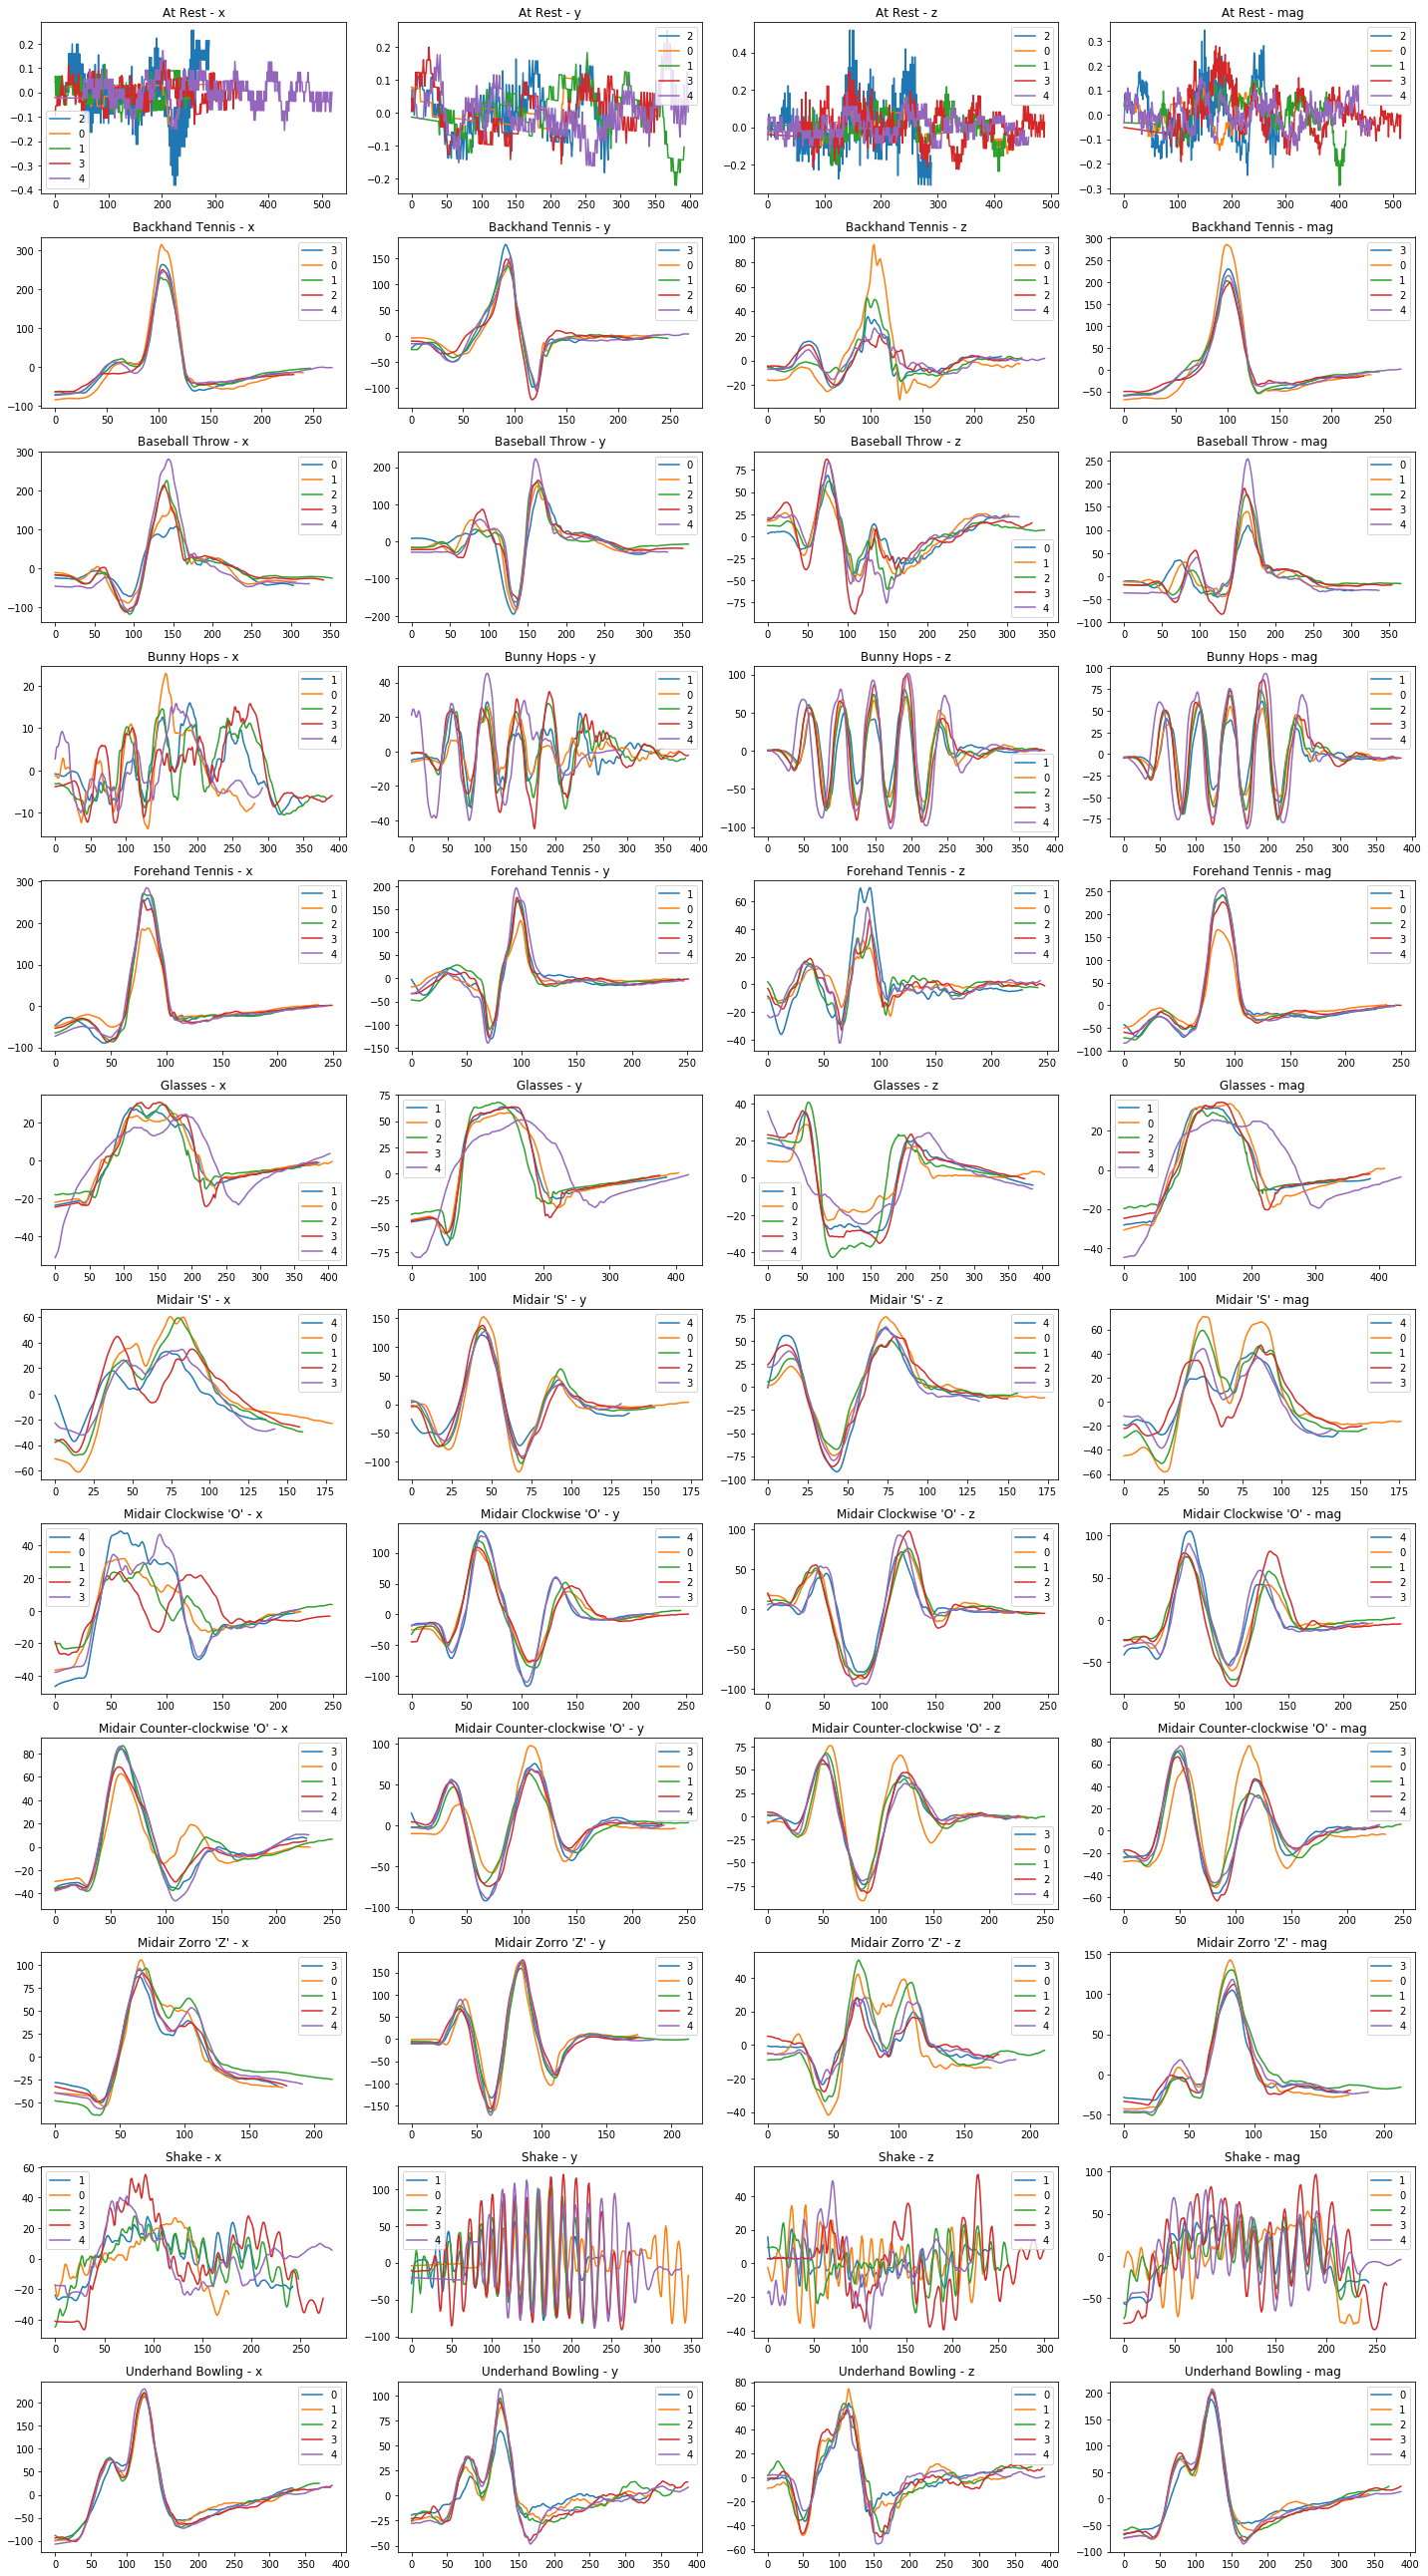

In [45]:
#visualizing aligned and smooth 
cnt=1
gestureNamesSorted = sorted(mapGestureToTrials.keys())
plt.figure(figsize=(20, 3 * len(mapGestureToTrials)))
for gestureName in gestureNamesSorted:
#for gestureName in ['Backhand Tennis']:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trials = {'x':[], 'y':[], 'z':[], 'mag':[]}
    
    trials['x'] = [x.accel.x for x in gestureTrials]
    trials['y'] = [x.accel.y for x in gestureTrials]
    trials['z'] = [x.accel.z for x in gestureTrials]
    trials['mag'] = [x.accel.mag for x in gestureTrials]
    trials['x_processed'] = []
    trials['y_processed'] = []
    trials['z_processed'] = []
    trials['mag_processed'] = []
    
    for key in ['x', 'y', 'z', 'mag']:
        plt.subplot(len(gestureNamesSorted), 4, cnt)
        lens = [len(x) for x in trials[key]]

        min_len = np.min(lens)
        min_arg = np.argmin(lens)

        a = smooth(trials[key][min_arg])
        #a = scipy.signal.detrend(smooth(trials[key][min_arg])
        #plt.plot(a, label=str(min_arg))
        plt.plot(scipy.signal.detrend(a), label=str(min_arg))
        
        #gestureTrials[min_arg].setProcessedAccel(scipy.signal.detrend(a))

        for i in range(0, 5):
            if i == min_arg:
                trials[key+'_processed'].append(scipy.signal.detrend(a))
                continue

            b = smooth(trials[key][i])
            #b = scipy.signal.detrend(smooth(trials[key][i]))
            padding, time_shift = align_fft(a, b)
            
            plt.title('%s - %s'%(gestureName, key))

            if padding:
                plt.plot(scipy.signal.detrend(np.pad(b, (time_shift,0), 'constant', constant_values=(b[0],b[-1]))), label=str(i))
                #plt.plot(np.pad(b, (time_shift,0), 'constant', constant_values=(b[0],b[-1])), label=str(i))
                trials[key+'_processed'].append(scipy.signal.detrend(np.pad(b, (time_shift,0), 'constant', constant_values=(b[0],b[-1]))))
            else:
                plt.plot(scipy.signal.detrend(b[time_shift:]), label=str(i))
                trials[key+'_processed'].append(scipy.signal.detrend(b[time_shift:]))
                #plt.plot(b[time_shift:], label=str(i))
            plt.legend()
        cnt+=1
        
    #storing processed signals
    x_min = np.min([len(s) for s in trials['x_processed']])
    y_min = np.min([len(s) for s in trials['y_processed']])
    z_min = np.min([len(s) for s in trials['z_processed']])
    mag_min = np.min([len(s) for s in trials['mag_processed']])
    for i in range(0, len(gestureTrials)):
        gestureTrials[i].setProcessedAccel(trials['x_processed'][i][:x_min], trials['y_processed'][i][:y_min], 
                                           trials['z_processed'][i][:z_min], trials['mag_processed'][i][:mag_min])
    mapGestureToTrials[gestureName] = gestureTrials

plt.tight_layout()        
plt.show()

# Visualize processed data to check whether it's correctly stored

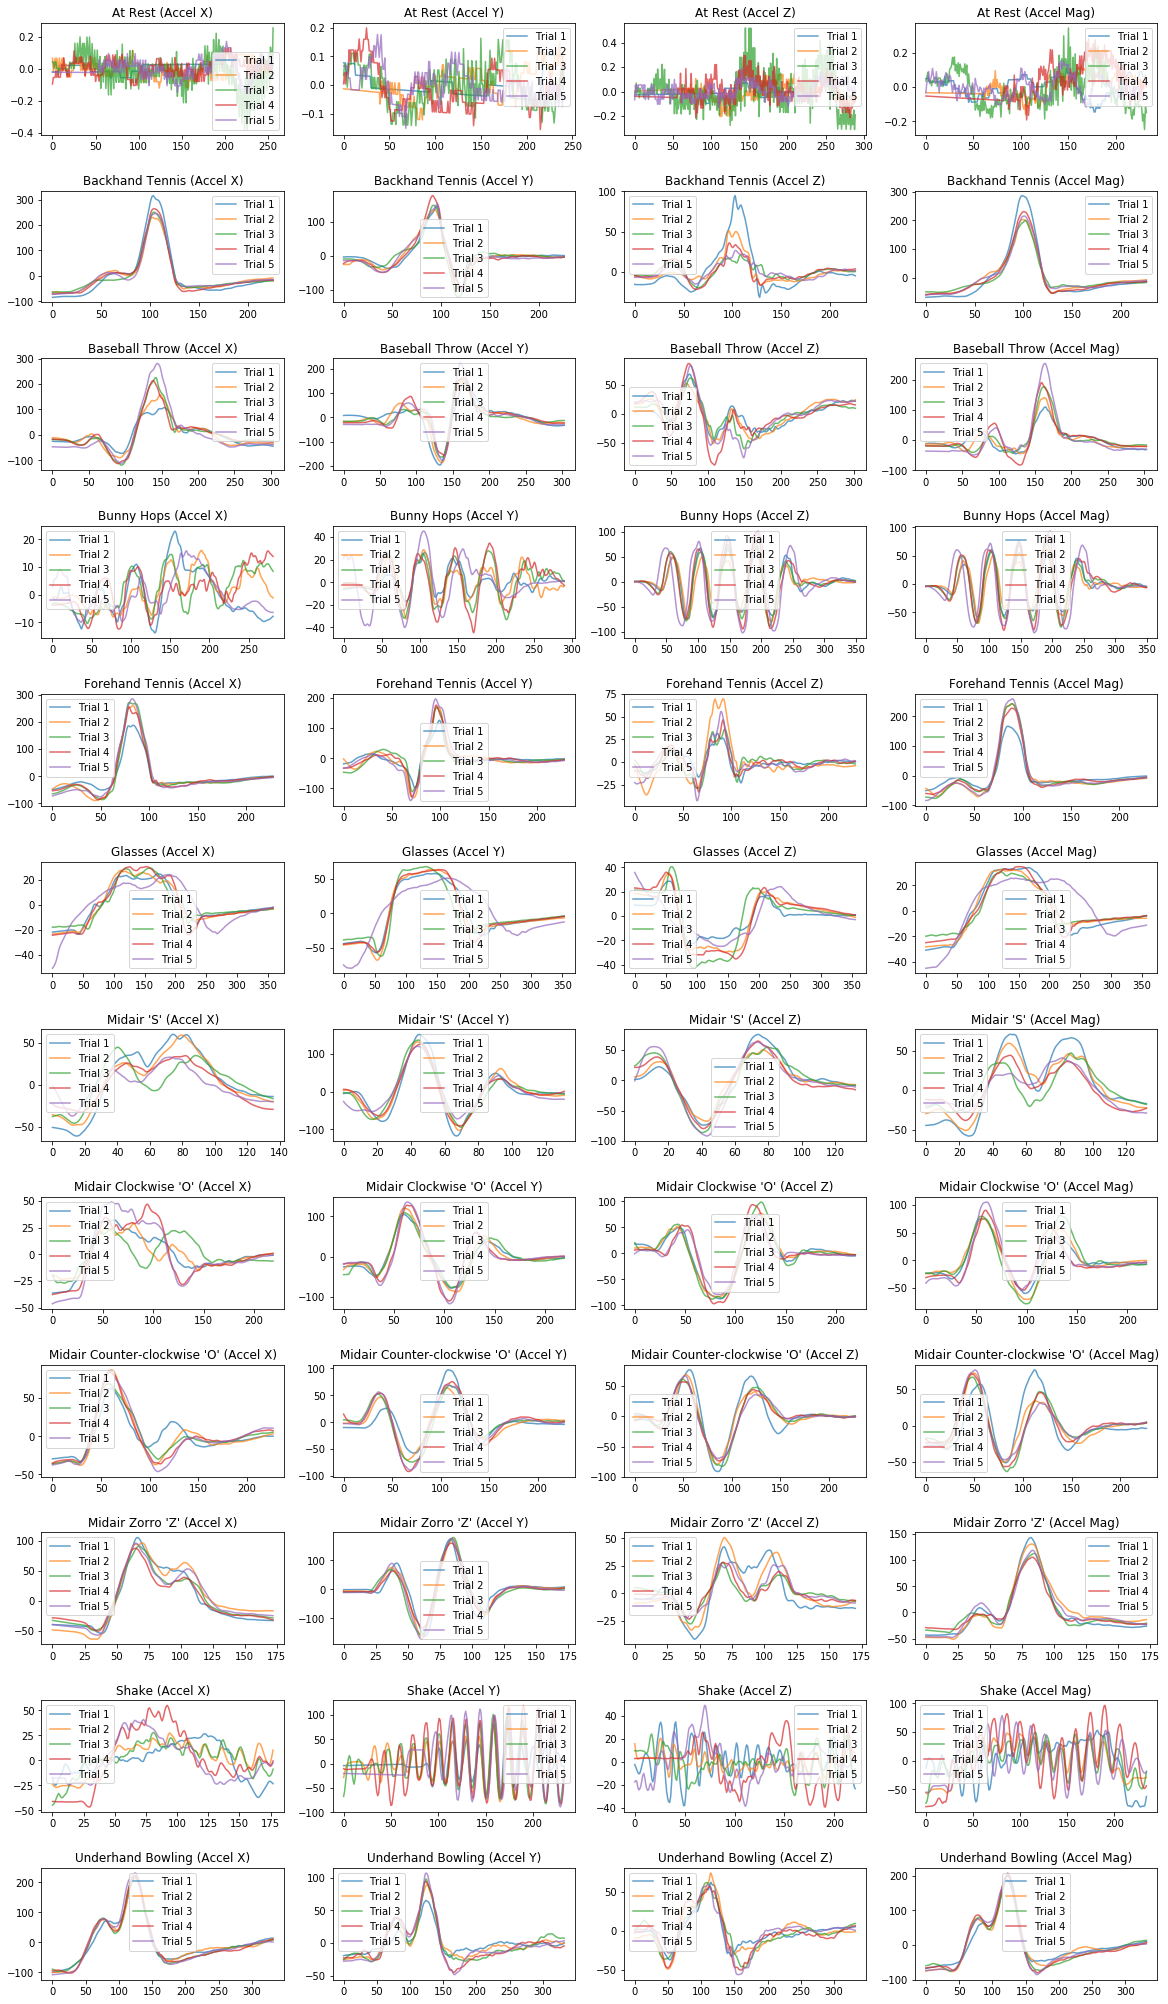

In [46]:
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.processed_accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.processed_accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.processed_accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.processed_accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1

# Build a recognizer 

In [47]:
#split data
from fastdtw import fastdtw
from sklearn.metrics import confusion_matrix

def aggregate_train_set(trials, test_idx):
    x = np.mean([x['x'] for i, x in enumerate(trials) if i != test_idx], axis=0)
    y = np.mean([x['y'] for i, x in enumerate(trials) if i != test_idx], axis=0)
    z = np.mean([x['z'] for i, x in enumerate(trials) if i != test_idx], axis=0)
    mag = np.mean([x['mag'] for i, x in enumerate(trials) if i != test_idx], axis=0)
    return {'x': x, 'y': y, 'z': z, 'mag': mag}

def split_gestures(mapGestureToTrials, gestureNamesSorted):
    train = [{}]*5
    test = [{}]*5

    test_set_idx = [0,1,2,3,4]
    np.random.shuffle(test_set_idx)
    
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]
        
        trials = np.array([{'x': np.array(g.processed_accel.x), 
                   'y': np.array(g.processed_accel.y), 
                   'z': np.array(g.processed_accel.z), 
                   'mag': np.array(g.processed_accel.mag)} for g in gestureTrials])
        
        for i, t in enumerate(test_set_idx):
            train[i][gestureName] = aggregate_train_set(trials, t)
            test[i][gestureName] = trials[t]
        
    return train, test

def visualize_train_test(train, test, mapGestureToTrials, gestureNamesSorted):
    fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
    fig.subplots_adjust(hspace=0.5)

    index=0

    for gestureName in gestureNamesSorted:
        axes[index][0].plot(train[gestureName]['x'], alpha=0.7, label="Train")
        axes[index][1].plot(train[gestureName]['y'], alpha=0.7, label="Train")
        axes[index][2].plot(train[gestureName]['z'], alpha=0.7, label="Train")
        axes[index][3].plot(train[gestureName]['mag'], alpha=0.7, label="Train")

        axes[index][0].plot(test[gestureName]['x'], alpha=0.7, label="Test")
        axes[index][1].plot(test[gestureName]['y'], alpha=0.7, label="Test")
        axes[index][2].plot(test[gestureName]['z'], alpha=0.7, label="Test")
        axes[index][3].plot(test[gestureName]['mag'], alpha=0.7, label="Test")

        axes[index][0].set_title(gestureName + " (Accel X)")
        axes[index][0].legend()

        axes[index][1].set_title(gestureName + " (Accel Y)")
        axes[index][1].legend()

        axes[index][2].set_title(gestureName + " (Accel Z)")
        axes[index][2].legend()

        axes[index][3].set_title(gestureName + " (Accel Mag)")
        axes[index][3].legend()
        index = index + 1
    
    plt.show()
        
def recognize_gesture(train, test, gestureNamesSorted):
    y_true = []
    y_pred = []
    for test_gesture, test_data in test.items():
        min_distance = 999999999
        min_distance_gesture = ''
        for train_gesture, train_data in train.items():
            dist_x, _ = fastdtw(test_data['x'], train_data['x'], dist=scipy.spatial.distance.euclidean)
            dist_y, _ = fastdtw(test_data['y'], train_data['y'], dist=scipy.spatial.distance.euclidean)
            dist_z, _ = fastdtw(test_data['z'], train_data['z'], dist=scipy.spatial.distance.euclidean)
            dist_mag, _ = fastdtw(test_data['mag'], train_data['mag'], dist=scipy.spatial.distance.euclidean)
            
            dist_sum = np.sum([dist_x, dist_y, dist_z, dist_mag])
            
            if min_distance > dist_sum:
                min_distance = dist_sum
                min_distance_gesture = train_gesture
            
        print(test_gesture, min_distance_gesture, min_distance)
        y_pred.append(min_distance_gesture)
        y_true.append(test_gesture)    
    
    return y_true, y_pred

# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

k=0


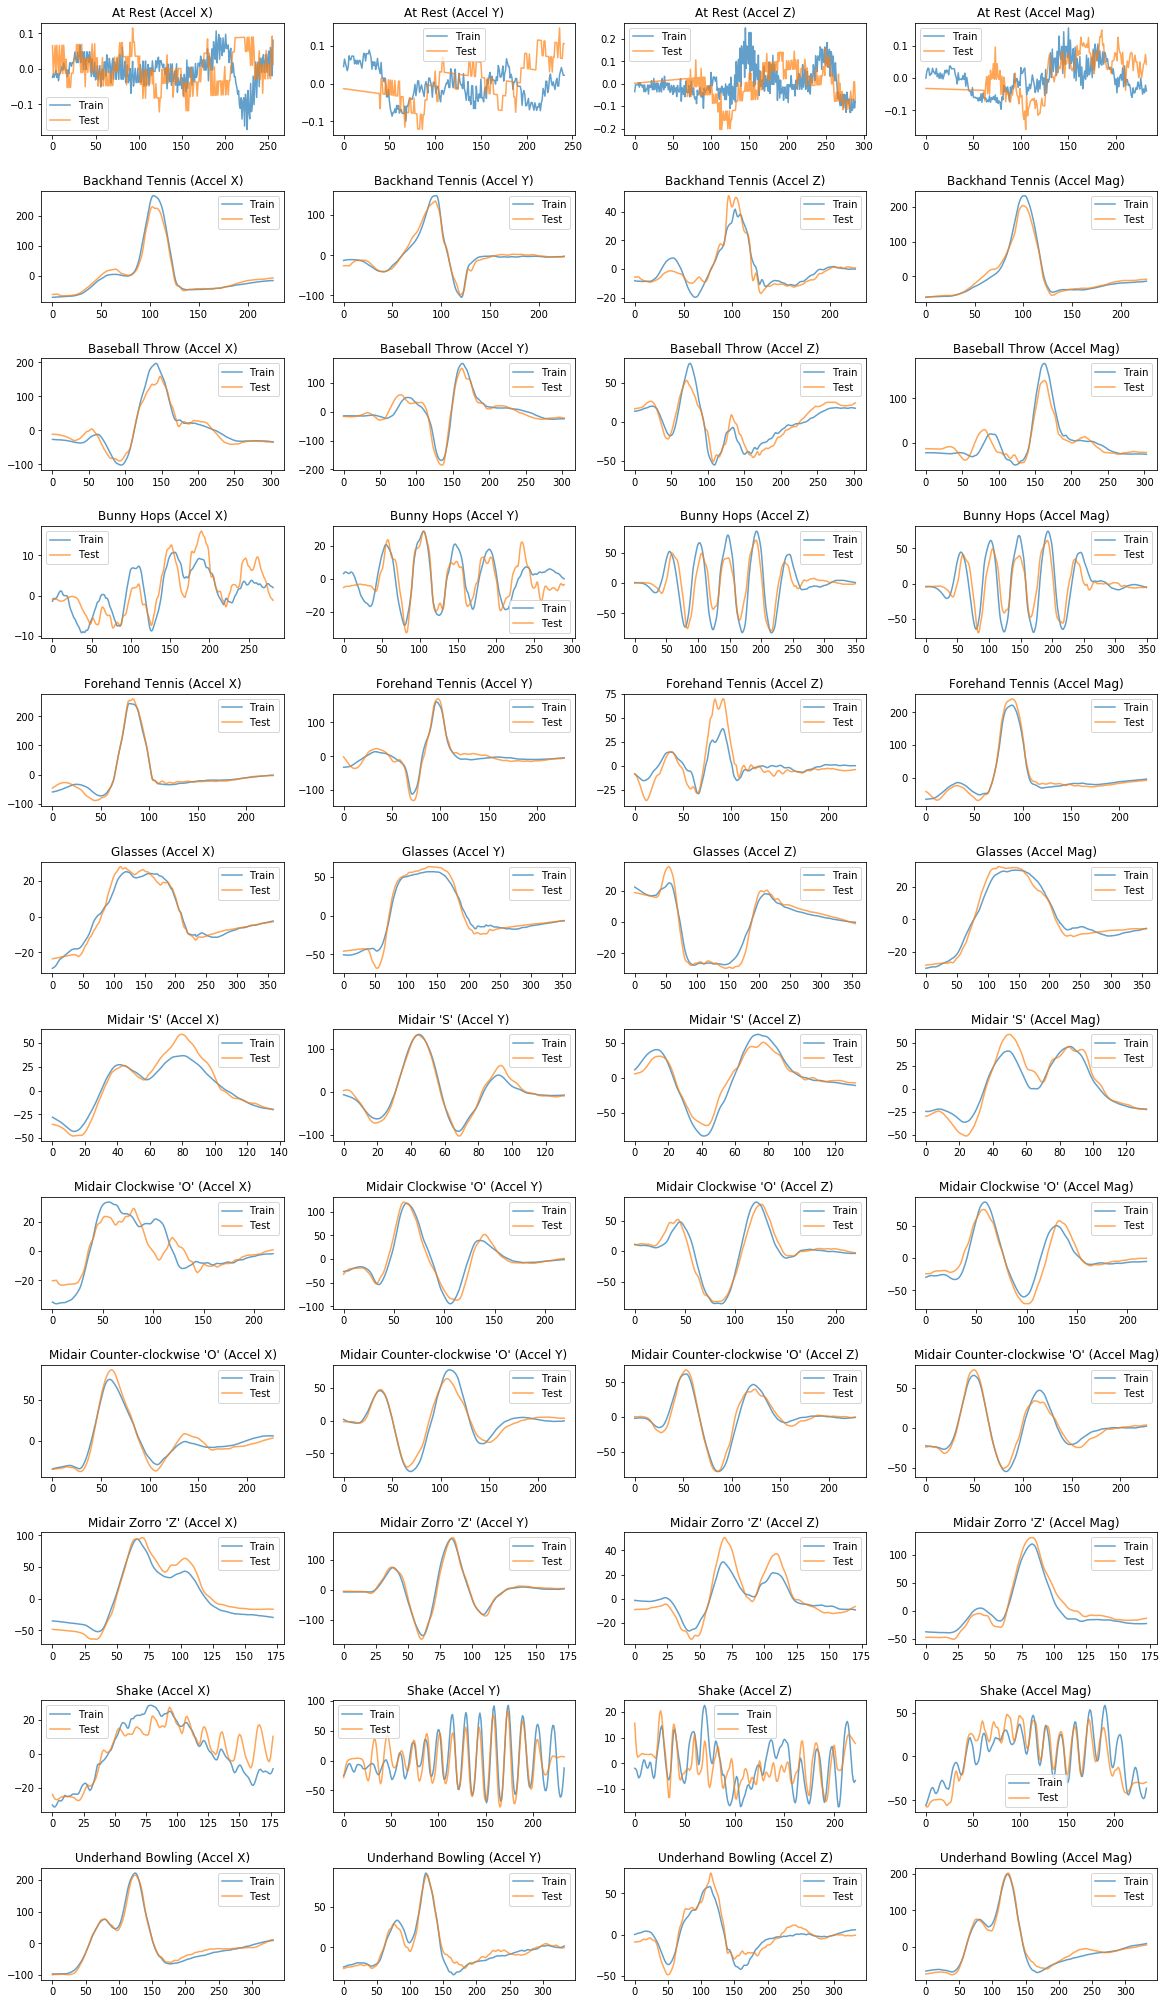

At Rest At Rest 34.89543599001912
Backhand Tennis Backhand Tennis 2777.304449112402
Baseball Throw Baseball Throw 5089.475402221447
Bunny Hops Bunny Hops 4794.661835809577
Forehand Tennis Forehand Tennis 3497.49687582205
Glasses Glasses 1665.5109088795532
Midair 'S' Midair 'S' 1926.6646560184367
Midair Clockwise 'O' Midair Clockwise 'O' 2175.490177759706
Midair Counter-clockwise 'O' Midair Counter-clockwise 'O' 1794.6580790929067
Midair Zorro 'Z' Midair Zorro 'Z' 3188.80571817766
Shake Shake 7445.11825844595
Underhand Bowling Underhand Bowling 3353.14391416657
k=1


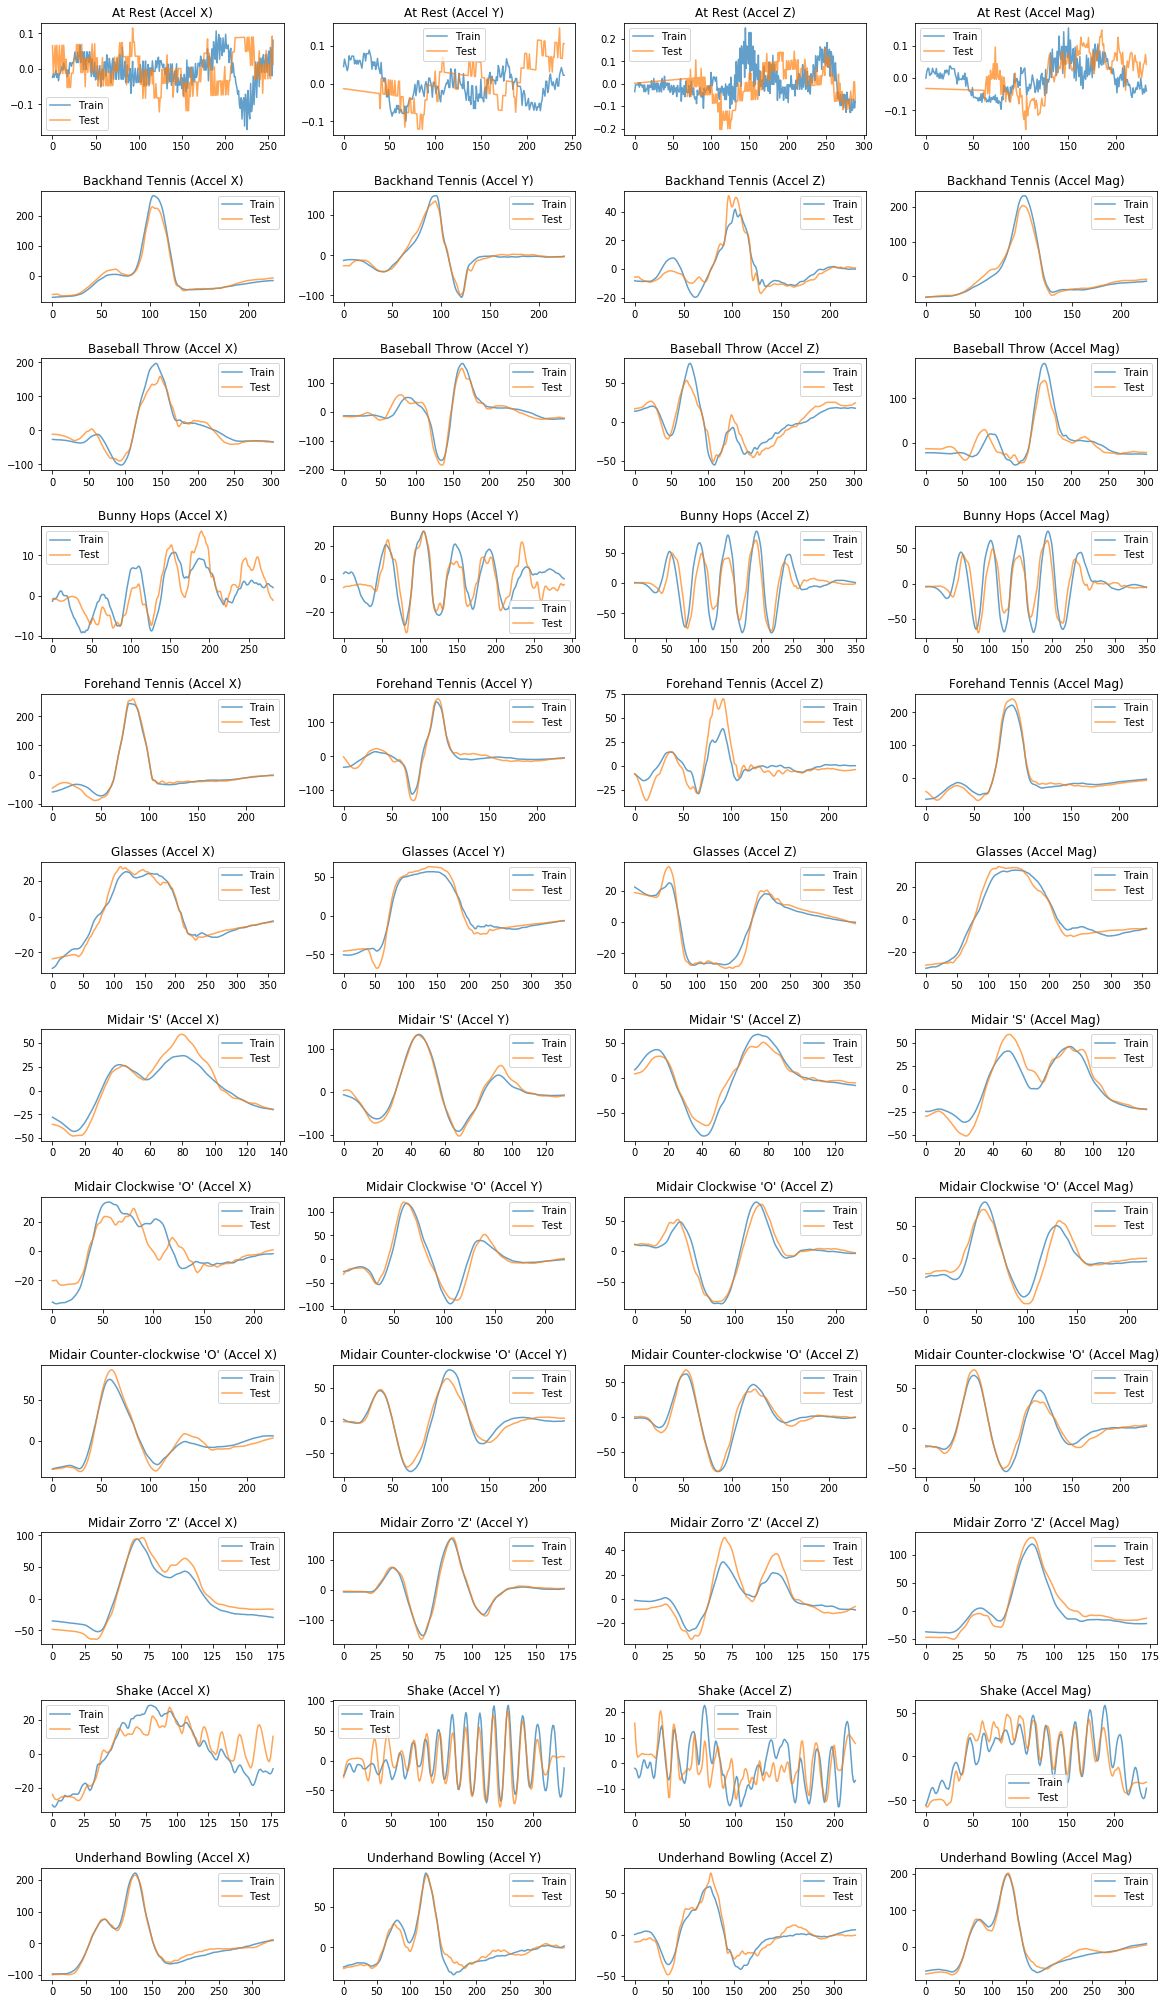

At Rest At Rest 34.89543599001912
Backhand Tennis Backhand Tennis 2777.304449112402
Baseball Throw Baseball Throw 5089.475402221447
Bunny Hops Bunny Hops 4794.661835809577
Forehand Tennis Forehand Tennis 3497.49687582205
Glasses Glasses 1665.5109088795532
Midair 'S' Midair 'S' 1926.6646560184367
Midair Clockwise 'O' Midair Clockwise 'O' 2175.490177759706
Midair Counter-clockwise 'O' Midair Counter-clockwise 'O' 1794.6580790929067
Midair Zorro 'Z' Midair Zorro 'Z' 3188.80571817766
Shake Shake 7445.11825844595
Underhand Bowling Underhand Bowling 3353.14391416657
k=2


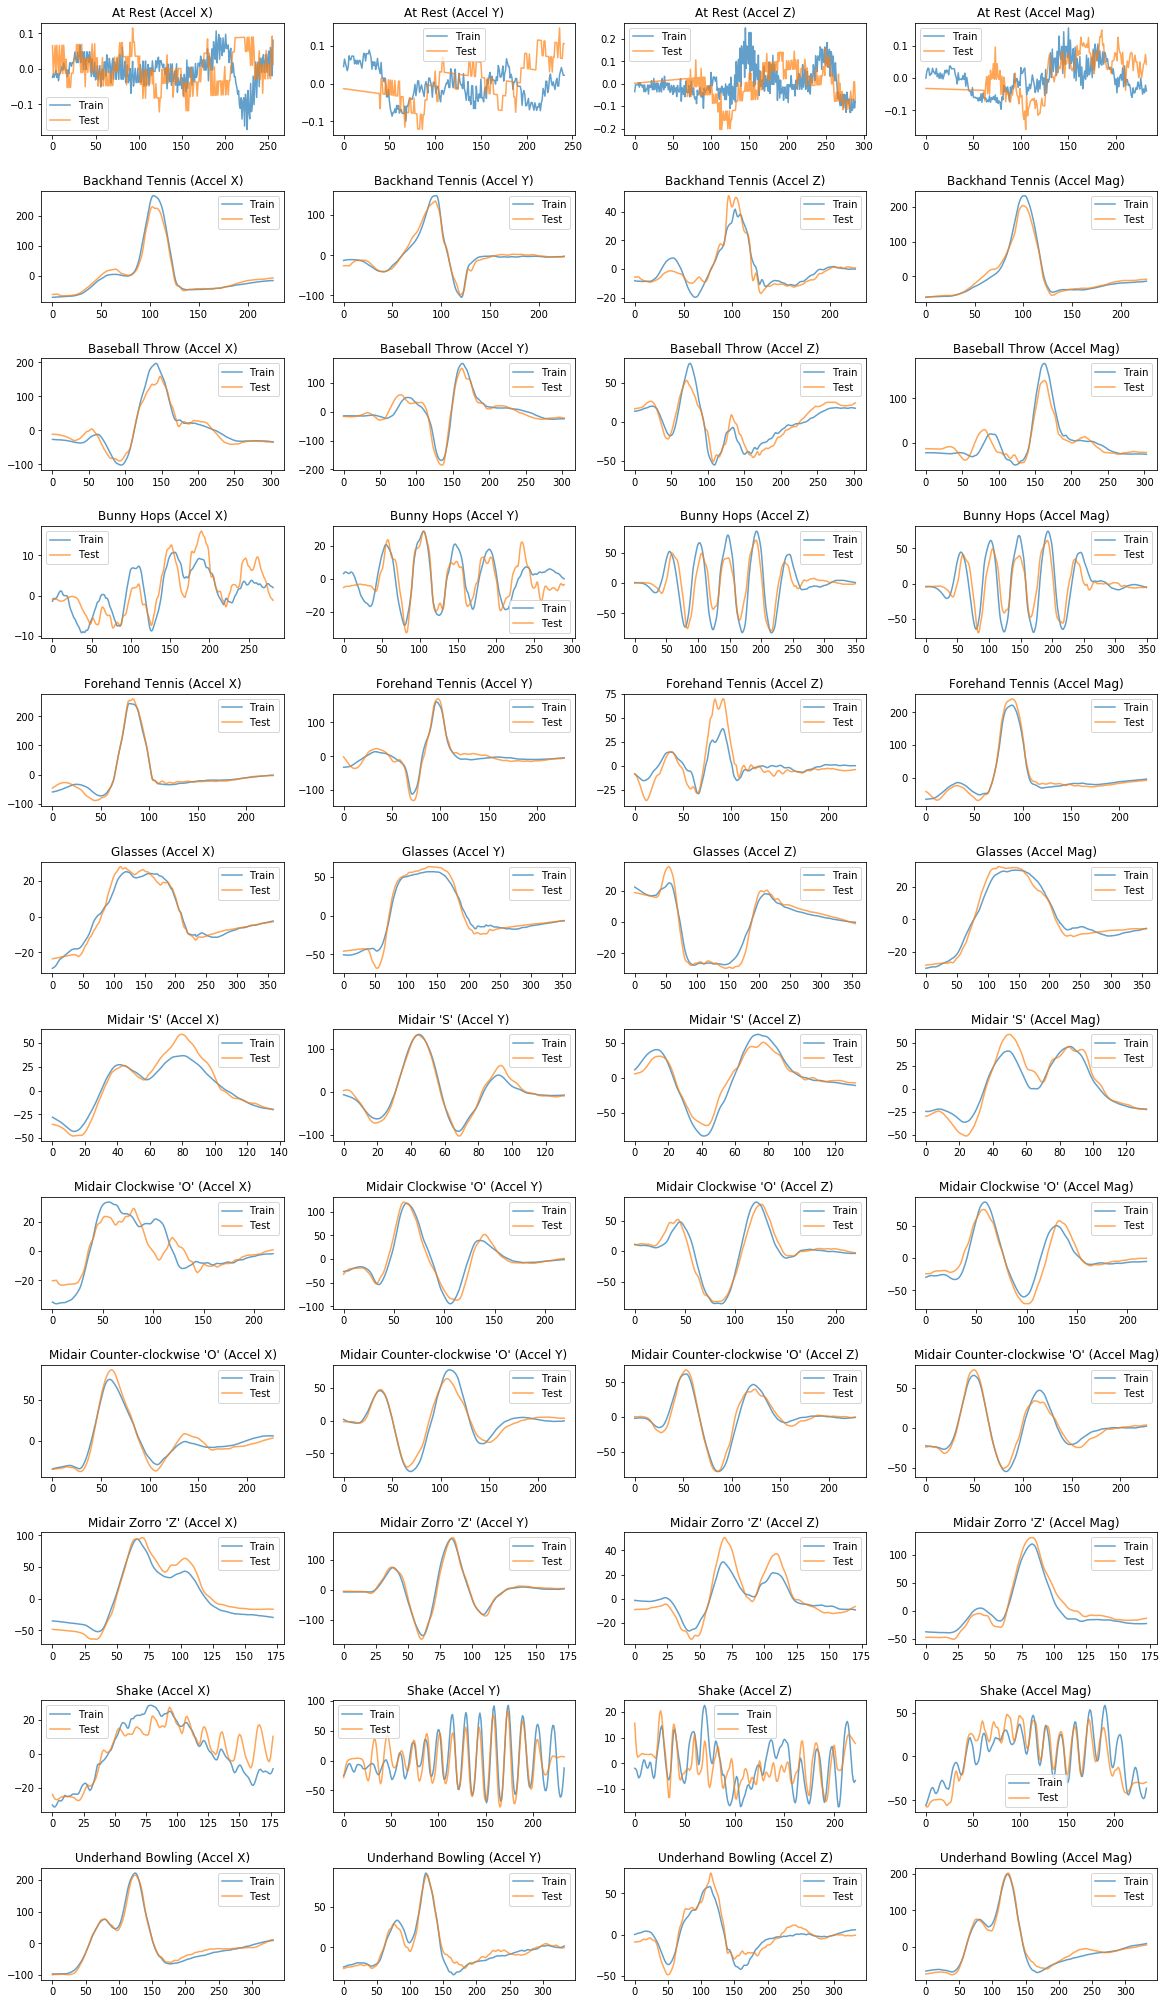

At Rest At Rest 34.89543599001912
Backhand Tennis Backhand Tennis 2777.304449112402
Baseball Throw Baseball Throw 5089.475402221447
Bunny Hops Bunny Hops 4794.661835809577
Forehand Tennis Forehand Tennis 3497.49687582205
Glasses Glasses 1665.5109088795532
Midair 'S' Midair 'S' 1926.6646560184367
Midair Clockwise 'O' Midair Clockwise 'O' 2175.490177759706
Midair Counter-clockwise 'O' Midair Counter-clockwise 'O' 1794.6580790929067
Midair Zorro 'Z' Midair Zorro 'Z' 3188.80571817766
Shake Shake 7445.11825844595
Underhand Bowling Underhand Bowling 3353.14391416657
k=3


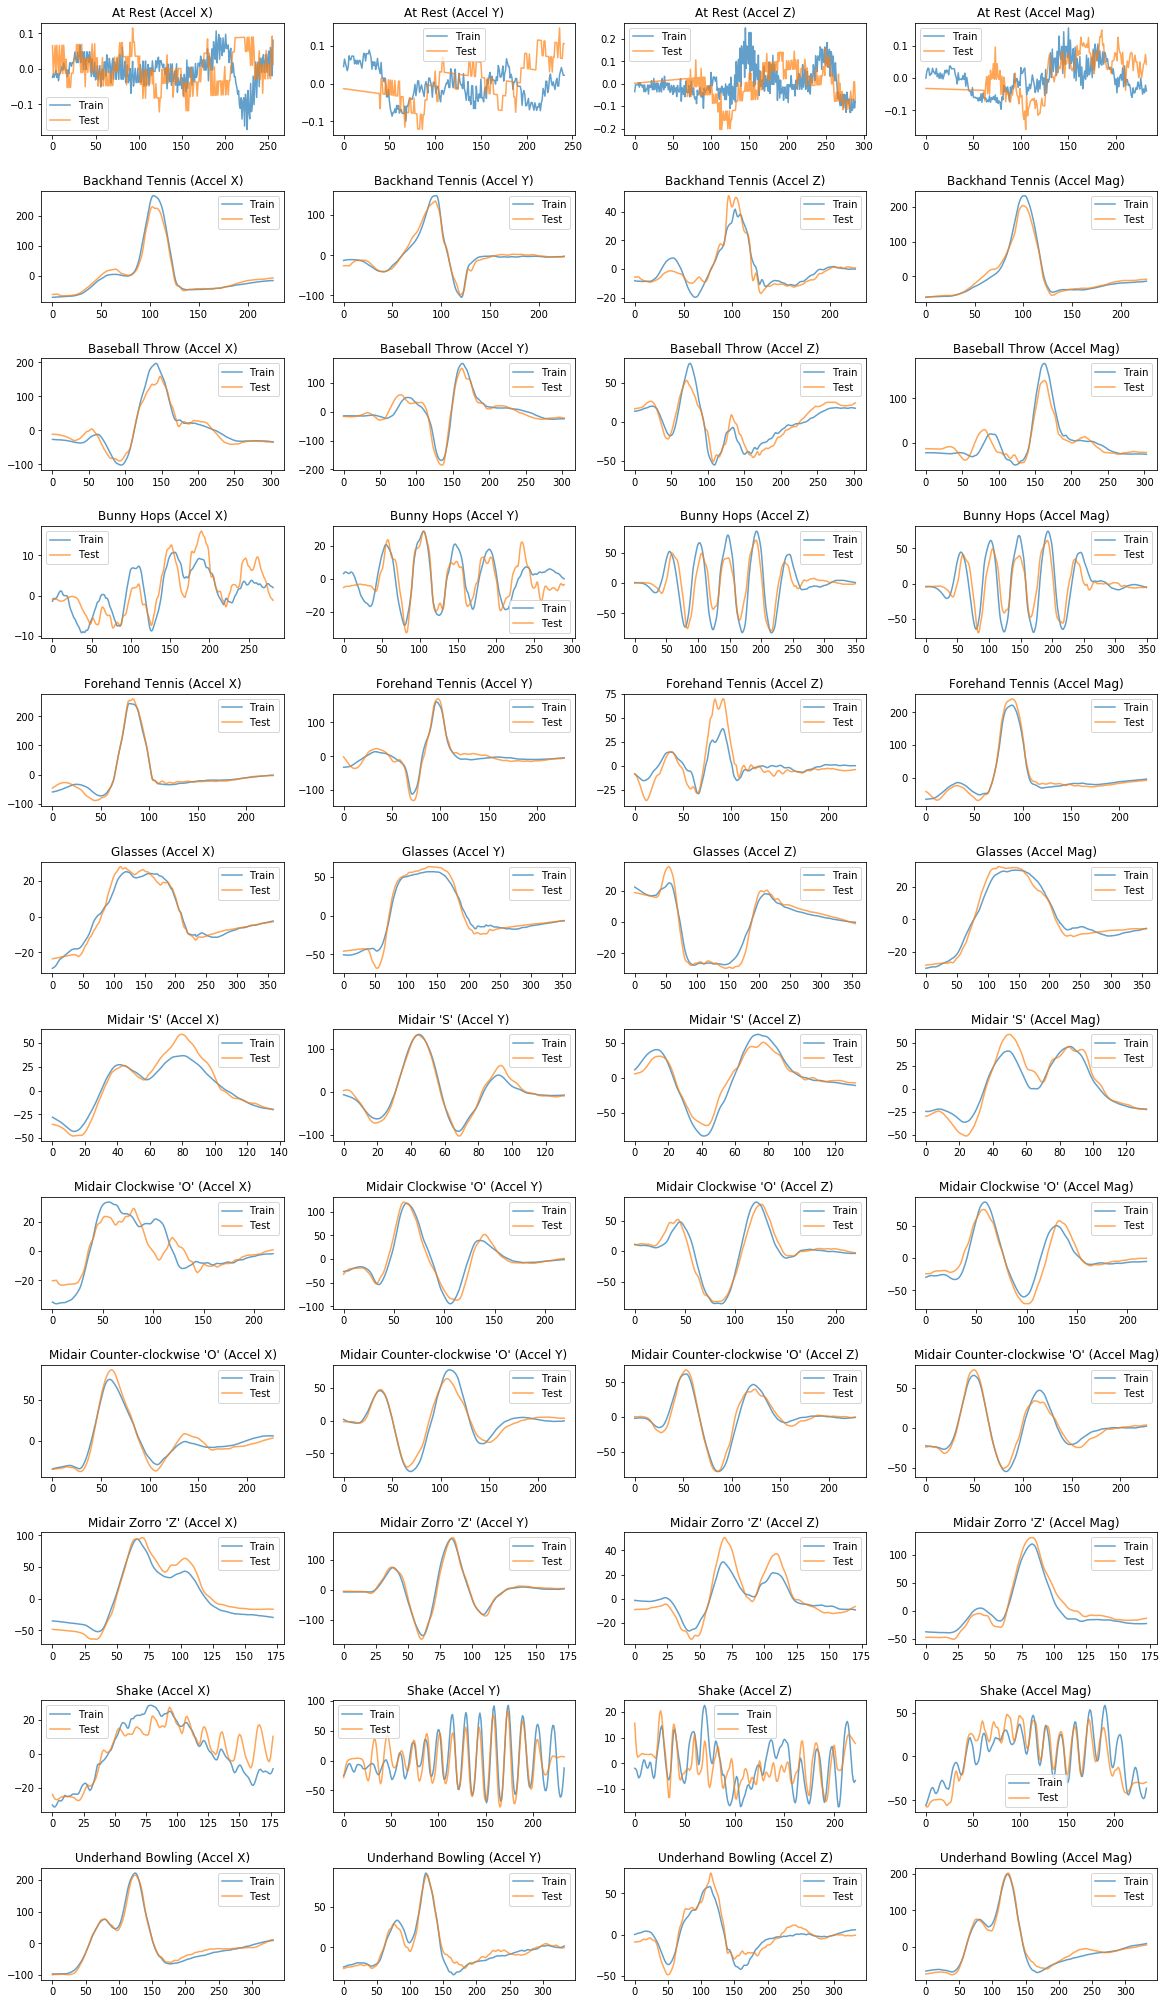

At Rest At Rest 34.89543599001912
Backhand Tennis Backhand Tennis 2777.304449112402
Baseball Throw Baseball Throw 5089.475402221447
Bunny Hops Bunny Hops 4794.661835809577
Forehand Tennis Forehand Tennis 3497.49687582205
Glasses Glasses 1665.5109088795532
Midair 'S' Midair 'S' 1926.6646560184367
Midair Clockwise 'O' Midair Clockwise 'O' 2175.490177759706
Midair Counter-clockwise 'O' Midair Counter-clockwise 'O' 1794.6580790929067
Midair Zorro 'Z' Midair Zorro 'Z' 3188.80571817766
Shake Shake 7445.11825844595
Underhand Bowling Underhand Bowling 3353.14391416657
k=4


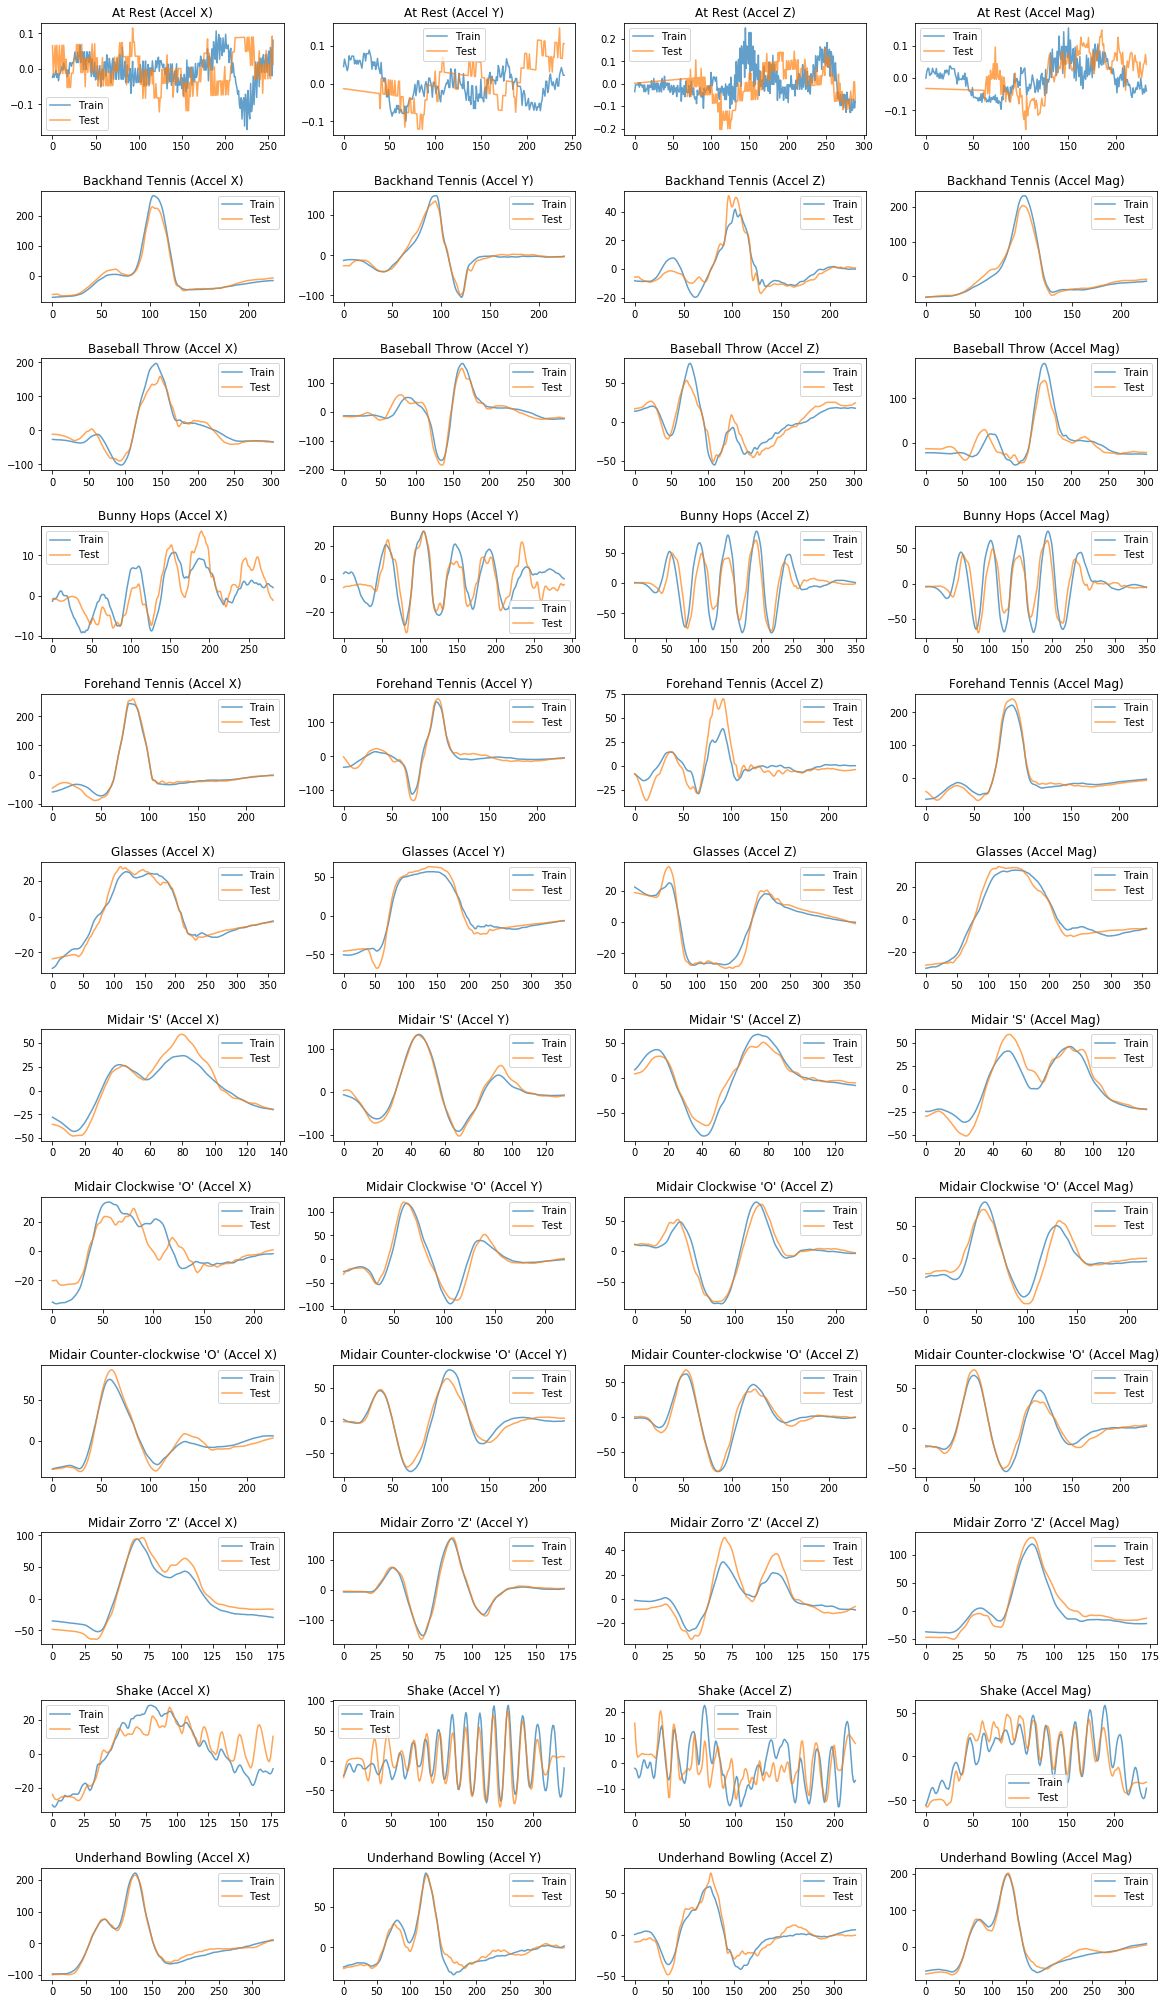

At Rest At Rest 34.89543599001912
Backhand Tennis Backhand Tennis 2777.304449112402
Baseball Throw Baseball Throw 5089.475402221447
Bunny Hops Bunny Hops 4794.661835809577
Forehand Tennis Forehand Tennis 3497.49687582205
Glasses Glasses 1665.5109088795532
Midair 'S' Midair 'S' 1926.6646560184367
Midair Clockwise 'O' Midair Clockwise 'O' 2175.490177759706
Midair Counter-clockwise 'O' Midair Counter-clockwise 'O' 1794.6580790929067
Midair Zorro 'Z' Midair Zorro 'Z' 3188.80571817766
Shake Shake 7445.11825844595
Underhand Bowling Underhand Bowling 3353.14391416657


In [48]:
train, test = split_gestures(mapGestureToTrials, gestureNamesSorted)

y_true=[]
y_pred=[]
for i in range(0, 5):
    print('k=%d'%i)
    visualize_train_test(train[i], test[i], mapGestureToTrials, gestureNamesSorted)
    y_t, y_p = recognize_gesture(train[i], test[i], gestureNamesSorted)
    
    y_true.extend(y_t)
    y_pred.extend(y_p)

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 5]]


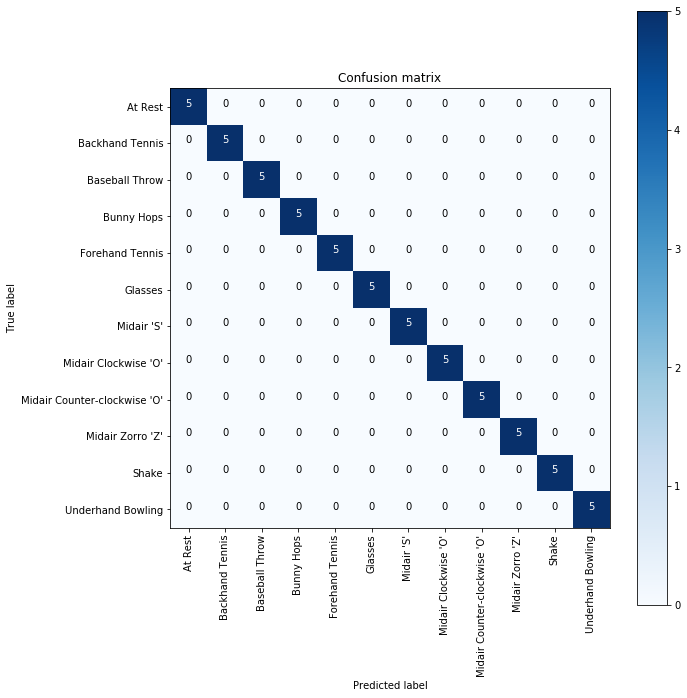

In [49]:
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=gestureNamesSorted)

In [35]:
from scipy import signal, fftpack
import numpy
a = numpy.array([0, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0])
b = numpy.array([0, 0, 0, 0, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0])
print(len(a))

len(a) - numpy.argmax(signal.correlate(a,b[:18]))-1, len(a)-numpy.argmax(signal.correlate(b[:18],a))-1

18


(3, -3)